In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris

In [2]:
# some utilities
### keep both training labels and ILI_type for y
def get_ili_type(df, keep_filter, label_col = ('labels', 'ILI_type')):
    ## get ILI training label and ILI type for y
    y = df.loc[keep_filter ,label_col]
    return y

### impute na by 0
### not ideal but should work for a start
def impute_na(df, value):
    return df.fillna(value)

def impute_back(df):
    return df.fillna(method= 'backfill', axis = 0)


### poisson sampling
def poisson_sampling(gamma, n, seed=1729):
    randm = np.random.RandomState(seed)
    flag = randm.binomial(1, gamma, n)
    return flag


import torch 
from torch import tensor

from autodp.calibrator_zoo import eps_delta_calibrator
from autodp.autodp_core import Mechanism
from autodp.mechanism_zoo import GaussianMechanism
from autodp.transformer_zoo import ComposeGaussian
import matplotlib.pyplot as plt
torch.manual_seed(0)

#common
def add_ones(data):
    # add ones column to raw data X
    # X should be n x d form and the return is in n x (d+1) form
    ones = np.repeat(1, data.shape[0])
    add_ones_data = np.insert(data, data.shape[1], ones, axis=1)
    return add_ones_data


def one_hot_encoding(y, category=4):
    # y is in {0,1,2,3}, do one_hot_encoding
    # return a matrix in 4 x n form
    enc = np.zeros([category, y.shape[0]])
    for j in range(y.shape[0]):
        enc[y[j],j]=1
    return enc


def softmax_activation(z):
    exponentials = torch.exp(z)
    exponentials_row_sums = torch.sum(exponentials, axis=1).unsqueeze(1)
    return exponentials / exponentials_row_sums


def cross_entropy_loss(y_one_hot, activations):
    loss = -torch.mean(torch.sum(y_one_hot * torch.log(activations), axis=1))    
    return loss


def add_gauss_noise(sigma, dim1, dim2):
    gauss_noise = torch.normal(mean=0, std=sigma, size=(dim1, dim2))
    return gauss_noise


# noisyGD
class NoisyGD_mech(Mechanism):
    def __init__(self,sigma,coeff,name='NoisyGD'):
        Mechanism.__init__(self)
        self.name = name
        self.params={'sigma':sigma,'coeff':coeff}
        
        # ----------- Implement noisy-GD here with "GaussianMechanism" and "ComposeGaussian" ----------------
        gm = GaussianMechanism(sigma, name='Release_gradient')
        compose = ComposeGaussian()
        mech = compose([gm],[coeff])
        # ------------- return a Mechanism object named 'mech' --------------------s
        self.set_all_representation(mech)       

        
def cal_grad(w, X, y, A):
    # calculate the full gradient
    w_gradients = -torch.mm(X.transpose(0, 1), y - A)
    
    return w_gradients


def clip_grad(w, threshod):
    #clip gradient per example
    clip = np.minimum(1., threshod/np.linalg.norm(w, 'fro'))
    
    return clip


def theoretical_lr_choice(beta_L, f0_minus_fniter_bound, dim, sigma, niter):
    # beta_L is the gradient lipschitz constant for the whole objective function
    # sigma is the variance of the gradient noise in each coordinate  (notice that this is the noise multiplier * GS)
    
    return np.minimum(1/beta_L,np.sqrt(2*f0_minus_fniter_bound / (dim * sigma**2 *beta_L*niter)))


def find_appropriate_niter(sigma, eps, delta):
    # Use autodp calibrator for selecting 'niter'
    NoisyGD_fix_sigma = lambda x:  NoisyGD_mech(sigma,x)
    calibrate = eps_delta_calibrator()
    mech = calibrate(NoisyGD_fix_sigma, eps, delta, [0,500000])
    niter = int(np.floor(mech.params['coeff']))
    
    return niter


def run_noisyGD(niter, learning_rate, clip_threshold, sigma, X, y, w, clip_or_not=False):
    record_loss = []
    dim1 = w.shape[0]
    dim2 = w.shape[1]
    for i in range(niter):
        Z = torch.mm(X, w)
        A = softmax_activation(Z)
        loss = cross_entropy_loss(y, A)
        record_loss.append(loss)
        
        w_gradients = cal_grad(w, X, y, A)
        
        if clip_or_not == False:
            w -= learning_rate * (w_gradients + add_gauss_noise(sigma, dim1, dim2))
        else:
            w -= learning_rate * (w_gradients*clip_grad(w_gradients,clip_threshold) + add_gauss_noise(sigma, dim1, dim2))
                
    return w, record_loss 
    
def logis_pred(X, w):
    pred = softmax_activation(torch.mm(X,w))
    return pred

def arg_max_vec(y):
    # convert to arg max by row
    return np.argmax(np.array(y), axis=1)

# noisyGD clf

In [3]:
X_irls, y_irls = load_iris(return_X_y=True)
y_irls = np.transpose(one_hot_encoding(y_irls, category=3))
n_sample = 150
n_class = 3
n_feature = 4


X = torch.tensor(X_irls, dtype=torch.float32)
y = torch.tensor(y_irls, dtype=torch.float32)
w = torch.rand((n_feature, n_class), requires_grad=False)


beta_L = n_sample/2
f0_minus_fniter_bound  = n_sample*np.log(2) # ADD YOUR CODE HERE
GS = 1
sigma = 1000
eps = 0.1
delta = 0.001
clip_threshold = 2000

n_iterations = find_appropriate_niter(sigma, eps, delta)
learning_rate = theoretical_lr_choice(beta_L,f0_minus_fniter_bound,n_feature,sigma*GS,n_iterations)

print(n_iterations)


#### begin training!
w_train, loss_train = run_noisyGD(niter=n_iterations, 
                  learning_rate=learning_rate, 
                  clip_threshold = clip_threshold, 
                  sigma=sigma, 
                  X=X, 
                  y=y, 
                  w=w,
                 clip_or_not=True
                 )

3301


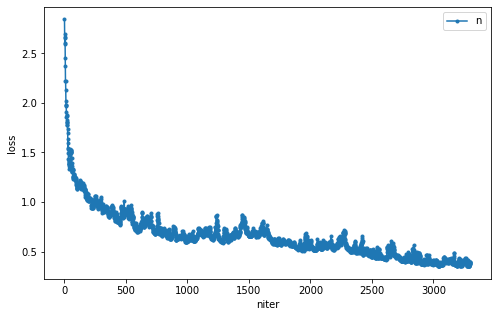

In [4]:
import matplotlib.pyplot as plt
#%matplotlib inline 
plt.figure(figsize=(8, 5))
plt.plot(np.arange(n_iterations), loss_train, marker=".")
plt.legend('noisyGD')
plt.xlabel('niter')
plt.ylabel('loss')
plt.show()

In [6]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = logis_pred(X, w_train)
print(classification_report(arg_max_vec(y), arg_max_vec(y_pred)))

cf = confusion_matrix(arg_max_vec(y), arg_max_vec(y_pred))#/np.array([6300,1050,1050,1050]).reshape(4,1)
print('confusion matrix:', cf)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        50
           1       0.93      0.74      0.82        50
           2       0.81      0.94      0.87        50

    accuracy                           0.89       150
   macro avg       0.90      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150

confusion matrix: [[50  0  0]
 [ 2 37 11]
 [ 0  3 47]]


# logistic clf

In [13]:
X, y = load_iris(return_X_y=True)
clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)

print(classification_report(y, y_pred))


clf.predict_proba(X[:2, :])
clf.score(X, y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.94      0.96        50
           2       0.94      0.98      0.96        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



/home/vec/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9733333333333334

In [12]:
y_pred = clf.predict(X)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])